In [371]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

In [372]:
# Utility Functions
def generate_colors(n):
    colors = []
    for i in range(n):
        ratio = i / max(n - 1, 1)

        r = max(0, min(1, abs(ratio * 6 - 3) - max(abs(ratio * 6 - 4) - 1, 0)))
        g = max(0, min(1, 1 - abs(ratio * 6 - 2)))
        b = max(0, min(1, 1 - abs(ratio * 6 - 4)))

        colors.append((r, g, b))
    return colors


In [373]:
def download_crypto_data(ticker="BTC-USD", period="1y", interval="1d"):
    data = yf.download(ticker, period=period, interval=interval)

    # Pilih kolom yang relevan dan drop missing
    data = data[["Open", "High", "Low", "Close", "Volume"]].dropna()

    # Jika kolom multiindex, ambil level pertama
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    return data

def fetch_crypto_data_history(symbols, period="1y", interval="1d"):
    crypto_data = {}
    successfully_fetched = []

    for symbol in symbols:
        try:
            ticker = yf.Ticker(f"{symbol}-USD")
            data = ticker.history(period=period, interval=interval)

            if len(data) > 100:  # Ensure enough data for grid trading
                # Ambil tanggal hari ini - 2 hari
                cutoff_date = (pd.Timestamp.today() - timedelta(days=2)).tz_localize('UTC')

                # Filter data sampai cutoff_date
                data = data[data.index <= cutoff_date]

                crypto_data[symbol] = data
                successfully_fetched.append(symbol)
                print(f"Successfully fetched data for: {successfully_fetched}\n")
            else:
                print(f"Insufficient data for {symbol}, skipping...\n")

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}\n")

    # df = pd.DataFrame(crypto_data)
    # print(f"Data Shape : {df.shape}")
    # print(f"\nMissing Value  : \n{df.isnull().sum()}")
    # print(f"Date Range (RECHECK FOR NEW COINS) : {df.index.min().date()} to {df.index.max().date()}\n")

    # print(f"DataFrame : \n{df.describe().round(2)}]\n")

    return crypto_data

In [374]:
crypto_symbols = ["BTC", "ETH", "SOL", "BNB"]
raw_crypto_data = fetch_crypto_data_history(crypto_symbols, period="1y", interval="1d")

Successfully fetched data for: ['BTC']

Successfully fetched data for: ['BTC', 'ETH']

Successfully fetched data for: ['BTC', 'ETH', 'SOL']

Successfully fetched data for: ['BTC', 'ETH', 'SOL', 'BNB']



--- BTC ---
Data Shape : (364, 7)
Date Range : 2024-10-20 to 2025-10-18
Data Quality Check Passed: No missing values or zero volume days.
--- ETH ---
Data Shape : (364, 7)
Date Range : 2024-10-20 to 2025-10-18
Data Quality Check Passed: No missing values or zero volume days.
--- SOL ---
Data Shape : (364, 7)
Date Range : 2024-10-20 to 2025-10-18
Data Quality Check Passed: No missing values or zero volume days.
--- BNB ---
Data Shape : (364, 7)
Date Range : 2024-10-20 to 2025-10-18
Data Quality Check Passed: No missing values or zero volume days.


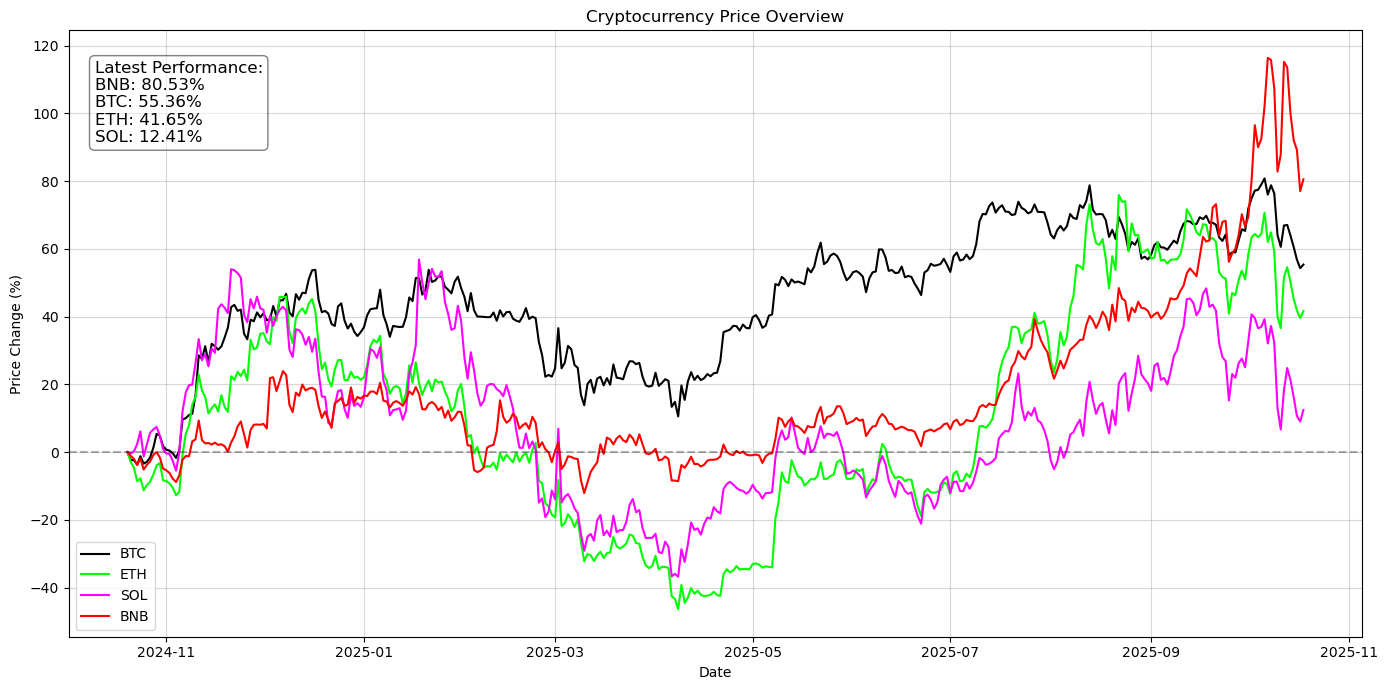

In [375]:
def crypto_data_overview(crypto_data):
    for symbol, data in crypto_data.items():
        print(f"--- {symbol} ---")
        print(f"Data Shape : {data.shape}")
        print(f"Date Range : {data.index.min().date()} to {data.index.max().date()}")

        # Check basic data quality
        missing_values = data.isnull().sum().sum()
        zero_volume = (data["Volume"] == 0).sum()

        if missing_values > 0:
            print(f"Missing Values Detected:\n{missing_values}")
        if zero_volume > 0:
            print(f"Zero Volume Days Detected: {zero_volume}")
        if missing_values == 0 and zero_volume == 0:
            print(f"Data Quality Check Passed: No missing values or zero volume days.")

def plot_price_overview(crypto_data):
    plt.figure(figsize=(14, 7))
    colors = generate_colors(len(crypto_data))

    latest_changes = []
    for i, (symbol, data) in enumerate(crypto_data.items()):
        normalized = (data["Close"] / data["Close"].iloc[0] - 1) * 100
        plt.plot(data.index, normalized, label=symbol, color=colors[i])
        change = normalized.iloc[-1]
        latest_changes.append(f"{symbol}: {change:.2f}%")

    # Sort latest_changes by percentage descending
    latest_changes.sort(key=lambda x: float(x.split(": ")[1][:-1]), reverse=True)

    plt.title("Cryptocurrency Price Overview")
    plt.xlabel("Date")
    plt.ylabel("Price Change (%)")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.axhline(0, color="black", linestyle="--", alpha=0.3)

    plt.text(
        0.02,
        0.95,
        "Latest Performance:\n" + "\n".join(latest_changes),
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    plt.tight_layout()
    plt.show()

crypto_data_overview(raw_crypto_data)
plot_price_overview(raw_crypto_data)

In [376]:
def clean_data_trading(data, symbol):
    print(f"\n=== Cleaning Data for {symbol} ===")
    original_length = len(data)
    cleaned = data.copy()

    # # 1️⃣ Cek missing values sebelum dihapus
    missing_before = cleaned.isnull().sum()
    if missing_before.any():
        print("\n[Before Cleaning] Missing Values per Column:")
        print(missing_before[missing_before > 0])
    else:
        print("\nNo missing values found — data looks clean ✅")

    # # 2️⃣ Hapus baris yang punya missing di kolom OHLCV
    cleaned = cleaned.dropna(subset=["Open", "High", "Low", "Close", "Volume"])
    print(f"\nRows dropped (missing OHLCV): {original_length - len(cleaned)}")

    # # 3️⃣ Cek inkonsistensi High/Low
    inconsistent_high = (cleaned["High"] < cleaned[["Open", "Close"]].max(axis=1)).sum()
    inconsistent_low = (cleaned["Low"] > cleaned[["Open", "Close"]].min(axis=1)).sum()
    print(f"Inconsistent High values: {inconsistent_high}")
    print(f"Inconsistent Low values: {inconsistent_low}")

    # # 4️⃣ Pastikan High >= Max(Open, Close) dan Low <= min(Open, Close)

    cleaned['High'] = np.maximum(cleaned['High'], np.maximum(cleaned['Open'], cleaned['Close']))
    cleaned['Low'] = np.minimum(cleaned['Low'], np.minimum(cleaned['Open'], cleaned['Close']))

    # # 5️⃣ Handle zero volume
    if 'Volume' in cleaned.columns:
        zero_vol_mask = cleaned['Volume'] <= 0
        if zero_vol_mask.sum() > 0:
            print(f"Need Fix {zero_vol_mask.sum()} volume")
            # Optionally: drop zero volume rows
            # cleaned = cleaned[~zero_vol_mask]

    # 6️⃣ Adjust Extreme Outlier
    for col in ['Open', 'High', 'Low', 'Close']:
        # Calculate Q1, Q3, and IQR
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for extreme outliers (using 3 * IQR)
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        # Identify extreme outliers
        outliers = (cleaned[col] < lower_bound) | (cleaned[col] > upper_bound)
        if outliers.sum() > 0:
            print(f"Adjust {outliers.sum()} extreme outliers in {col}")
            # Instead of removing, cap the values at bounds
            cleaned[col] = cleaned[col].clip(lower=lower_bound, upper=upper_bound)
        else:
            print('No Outlier Found')
    
    # 7️⃣ Sort by date (ensure chronological order)
    cleaned = cleaned.sort_index()
    print(f"Data sorted chronologically from {cleaned.index[0].date()} to {cleaned.index[-1].date()}")
    print(f"\nFinal shape: {cleaned.shape} (removed {original_length - len(cleaned)} rows)\n")

    return cleaned

clean_crypto_data = {}
for symbol, data in raw_crypto_data.items():
    clean_crypto_data[symbol] = clean_data_trading(data, symbol)


=== Cleaning Data for BTC ===

No missing values found — data looks clean ✅

Rows dropped (missing OHLCV): 0
Inconsistent High values: 0
Inconsistent Low values: 0
No Outlier Found
No Outlier Found
No Outlier Found
No Outlier Found
Data sorted chronologically from 2024-10-20 to 2025-10-18

Final shape: (364, 7) (removed 0 rows)


=== Cleaning Data for ETH ===

No missing values found — data looks clean ✅

Rows dropped (missing OHLCV): 0
Inconsistent High values: 0
Inconsistent Low values: 0
No Outlier Found
No Outlier Found
No Outlier Found
No Outlier Found
Data sorted chronologically from 2024-10-20 to 2025-10-18

Final shape: (364, 7) (removed 0 rows)


=== Cleaning Data for SOL ===

No missing values found — data looks clean ✅

Rows dropped (missing OHLCV): 0
Inconsistent High values: 0
Inconsistent Low values: 0
No Outlier Found
No Outlier Found
No Outlier Found
No Outlier Found
Data sorted chronologically from 2024-10-20 to 2025-10-18

Final shape: (364, 7) (removed 0 rows)


===

In [377]:
def quick_quality_check(crypto_data) :
    all_good = True

    for symbol, data in crypto_data.items():
        print(f"\n{symbol}:\n")
        issues = []

        # Check for missing values
        missing_values = data.isnull().sum()
        if missing_values.any():
            issues.append(f"Missing values detected:\n{missing_values[missing_values > 0]}")

        # Check for Zero price
        zero_prices = (data[['Open', 'High', 'Low', 'Close']] <= 0).sum()
        if zero_prices.any():
            issues.append(f"Zero or negative prices detected:\n{zero_prices[zero_prices > 0]}")

        # Check for data length
        min_required_rows = 100  # Minimum required days of data
        if len(data) < min_required_rows:
            issues.append(f"Insufficient data: {len(data)} rows (minimum {min_required_rows} required)")

        # Check date continuity
        all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
        missing_dates = all_dates.difference(data.index)
        if len(missing_dates) > 0:
            issues.append(f"Missing dates detected: {missing_dates}")

        if issues:
            all_good = False
            print("Issues found:")
            for issue in issues:
                print(f"- {issue}")
        else:
            print("All checks passed!")

    return all_good

data_quality_ok = quick_quality_check(clean_crypto_data)


BTC:

All checks passed!

ETH:

All checks passed!

SOL:

All checks passed!

BNB:

All checks passed!


In [378]:
def volatility_analyze_for_grid(crypto_data):
    volatility_data = {}

    for symbol, data in crypto_data.items():
        # Calculate daily returns
        returns = data["Close"].pct_change().dropna()

        # Different volatility measures
        hourly_volatility = returns.std() * np.sqrt(1/24) * 100
        four_hour_volatility = returns.std() * np.sqrt(1/6) * 100
        daily_volatility = returns.std() * 100
        weekly_volatility = returns.std() * np.sqrt(7) * 100
        monthly_volatility = returns.std() * np.sqrt(30) * 100
        annual_volatility = returns.std() * np.sqrt(365) * 100

        # Price range analysis
        avg_daily_range = ((data["High"] - data["Low"]) / data["Close"] * 100).mean()
        tf_factor = {
            "hourly": 1 / np.sqrt(24),
            "four_hour": 1 / np.sqrt(6),
            "daily": 1,
            "weekly": np.sqrt(7),
            "monthly": np.sqrt(30),
            "annual": np.sqrt(365),
        }

        # --- Hitung average range by timeframe
        avg_range_by_tf = {tf: avg_daily_range * factor for tf, factor in tf_factor.items()}

        volatility_data[symbol] = {
            "hourly_volatility": hourly_volatility,
            "four_hour_volatility": four_hour_volatility,
            "daily_volatility": daily_volatility,
            "weekly_volatility": weekly_volatility,
            "monthly_volatility": monthly_volatility,
            "annual_volatility": annual_volatility,
            "average_range": avg_range_by_tf,
        }
    
    # 4️⃣ Hitung threshold dari persentil volatilitas (dynamic)
    hourly_vols = np.array([v["hourly_volatility"] for v in volatility_data.values()])
    four_hour_vols = np.array([v["four_hour_volatility"] for v in volatility_data.values()])
    daily_vols = np.array([v["daily_volatility"] for v in volatility_data.values()])
    weekly_vols = np.array([v["weekly_volatility"] for v in volatility_data.values()])
    monthly_vols = np.array([v["monthly_volatility"] for v in volatility_data.values()])
    annual_vols = np.array([v["annual_volatility"] for v in volatility_data.values()])

    thresholds = {
        "hourly": np.percentile(hourly_vols, [33, 66]),   # low/medium/high
        "four_hour": np.percentile(four_hour_vols, [33, 66]),   # low/medium/high
        "daily": np.percentile(daily_vols, [33, 66]),   # low/medium/high
        "weekly": np.percentile(weekly_vols, [33, 66]),
        "monthly": np.percentile(monthly_vols, [33, 66]),
        "annual": np.percentile(annual_vols, [33, 66]),
    }

    # Print thresholds neatly and classify coins
    print("\n=== Volatility Thresholds and Classifications ===")
    
    for symbol in crypto_symbols:
        print(f"\n{symbol} Classifications:")
        for timeframe in ["hourly", "four_hour", "daily", "weekly", "monthly", "annual"]:
            vol = volatility_data[symbol][f"{timeframe}_volatility"]
            lower, upper = thresholds[timeframe]
            
            if vol < lower:
                status = "Low"
            elif vol > upper:
                status = "High"
            else:
                status = "Medium"
                
            print(f"{timeframe.capitalize()} Volatility: {vol:.2f}% ({status})")
            print(f"  Threshold - Low: {lower:.2f}%, High: {upper:.2f}%")

    # Sort volatility for recommendations
    sorted_volatility = sorted(
        [(k, v["annual_volatility"]) for k, v in volatility_data.items()],
        key=lambda x: x[1],
        reverse=True,
    )

    # Print rankings for each timeframe
    print("\n=== Hourly Volatility Rankings ===")
    hourly_sorted = sorted([(k, v["hourly_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in hourly_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== 4H Volatility Rankings ===")
    four_hour_sorted = sorted([(k, v["four_hour_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in four_hour_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Daily Volatility Rankings ===")
    daily_sorted = sorted([(k, v["daily_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in daily_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Weekly Volatility Rankings ===")
    weekly_sorted = sorted([(k, v["weekly_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in weekly_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Monthly Volatility Rankings ===")
    monthly_sorted = sorted([(k, v["monthly_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in monthly_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Annual Volatility Rankings ===")
    for symbol, vol in sorted_volatility:
        print(f"{symbol}: {vol:.2f}%")


    # Menentukan Best Alpha
    timeframes = ["hourly", "four_hour", "daily", "weekly", "monthly", "annual"]
    pair_alphas = {}

    for symbol, data in volatility_data.items():
        pair_alphas[symbol] = {}

        for tf in timeframes:
            # Ambil volatilitas & range pair ini untuk TF tertentu
            vol = data[f"{tf}_volatility"]
            avg_range = data["average_range"][tf]

            # Ambil distribusi volatilitas semua pair (baseline per TF)
            all_vols = np.array([v[f"{tf}_volatility"] for v in volatility_data.values()])
            mean_vol = all_vols.mean()
            std_vol = all_vols.std(ddof=0)

            # Hitung z-score pair ini relatif terhadap distribusi semua pair
            z_score = (vol - mean_vol) / std_vol

            # Range alpha untuk diuji
            dispersion = np.std([v[f"{tf}_volatility"] for v in volatility_data.values()])
            low_alpha = max(0.1, dispersion * 0.5)
            high_alpha = min(1.0, dispersion * 2.0)
            alphas = np.linspace(low_alpha, high_alpha, 80)
            errors = []

            # 🔁 Loop semua kandidat alpha dan hitung error prediksi
            for a in alphas:
                # Rumus multiplier berbasis alpha dan z-score
                multiplier = 1 + a * z_score

                # Prediksi range berdasarkan baseline mean_vol dan multiplier
                predicted_range = multiplier * mean_vol

                # Error antara prediksi dan aktual
                error = abs(predicted_range - avg_range)
                errors.append((a, error))

            # Pilih alpha dengan error terkecil
            best_alpha, _ = min(errors, key=lambda x: x[1])
            pair_alphas[symbol][tf] = round(float(best_alpha), 3)

    # Tampilkan hasil
    print("\n=== Optimal Alpha per Pair per Timeframe ===")
    for symbol, tf_data in pair_alphas.items():
        print(f"\n{symbol}:")
        for tf, alpha in tf_data.items():
            print(f"  {tf:<10} → {alpha}")

    # Menentukan Multiplier Data-driven
    grid_multipliers = {}

    for symbol, data in volatility_data.items():
        grid_multipliers[symbol] = {}

        for tf in timeframes:
            # ambil semua volatilitas untuk TF ini (untuk baseline distribusi)
            all_vols = np.array([v[f"{tf}_volatility"] for v in volatility_data.values()])
            mean_vol = all_vols.mean()
            std_vol = all_vols.std()

            # z-score pair ini terhadap distribusi semua aset
            z_score = (data[f"{tf}_volatility"] - mean_vol) / std_vol

            # alpha yang sudah kamu temukan
            alpha = pair_alphas[symbol][tf]

            # multiplier dinamis berbasis z-score
            multiplier = 1 + alpha * z_score

            # pastikan multiplier tetap positif & reasonable
            multiplier = np.clip(multiplier, 0.8, 2.5)

            grid_multipliers[symbol][tf] = round(float(multiplier), 3)

    # tampilkan hasil
    print("\n=== Dynamic Grid Multipliers per Pair per Timeframe ===")
    for symbol, tf_data in grid_multipliers.items():
        print(f"\n{symbol}:")
        for tf, m in tf_data.items():
            print(f"  {tf:<10} → {m}")


    # 5️⃣ Grid Spacing berdasarkan threshold dinamis
    print("\n=== Dynamic Grid Trading Spacing Recommendations ===")

    for symbol, data in volatility_data.items():
        print(f"\n{symbol} Recommended Grid Spacing:")

        for tf in ["hourly", "four_hour", "daily", "weekly", "monthly", "annual"]:
            avg_range = data["average_range"][tf]   # 🔹 ambil sesuai timeframe
            mult = grid_multipliers[symbol][tf]     # 🔹 multiplier hasil optimasi
            spacing = avg_range * mult              # 🔹 hasil akhir: grid spacing dinamis (%)
            print(f"{tf.capitalize():<10}: {spacing:.2f}%")

    return volatility_data

volatility_analysis = volatility_analyze_for_grid(clean_crypto_data)


=== Volatility Thresholds and Classifications ===

BTC Classifications:
Hourly Volatility: 0.48% (Low)
  Threshold - Low: 0.51%, High: 0.81%
Four_hour Volatility: 0.96% (Low)
  Threshold - Low: 1.02%, High: 1.63%
Daily Volatility: 2.34% (Low)
  Threshold - Low: 2.51%, High: 3.99%
Weekly Volatility: 6.20% (Low)
  Threshold - Low: 6.64%, High: 10.56%
Monthly Volatility: 12.83% (Low)
  Threshold - Low: 13.75%, High: 21.86%
Annual Volatility: 44.77% (Low)
  Threshold - Low: 47.95%, High: 76.26%

ETH Classifications:
Hourly Volatility: 0.82% (High)
  Threshold - Low: 0.51%, High: 0.81%
Four_hour Volatility: 1.64% (High)
  Threshold - Low: 1.02%, High: 1.63%
Daily Volatility: 4.02% (High)
  Threshold - Low: 2.51%, High: 3.99%
Weekly Volatility: 10.64% (High)
  Threshold - Low: 6.64%, High: 10.56%
Monthly Volatility: 22.03% (High)
  Threshold - Low: 13.75%, High: 21.86%
Annual Volatility: 76.83% (High)
  Threshold - Low: 47.95%, High: 76.26%

SOL Classifications:
Hourly Volatility: 0.94% (Hi

C:\Users\Zuhal\AppData\Local\Temp\ipykernel_808\3348748208.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


IndexError: index 4 is out of bounds for axis 0 with size 4

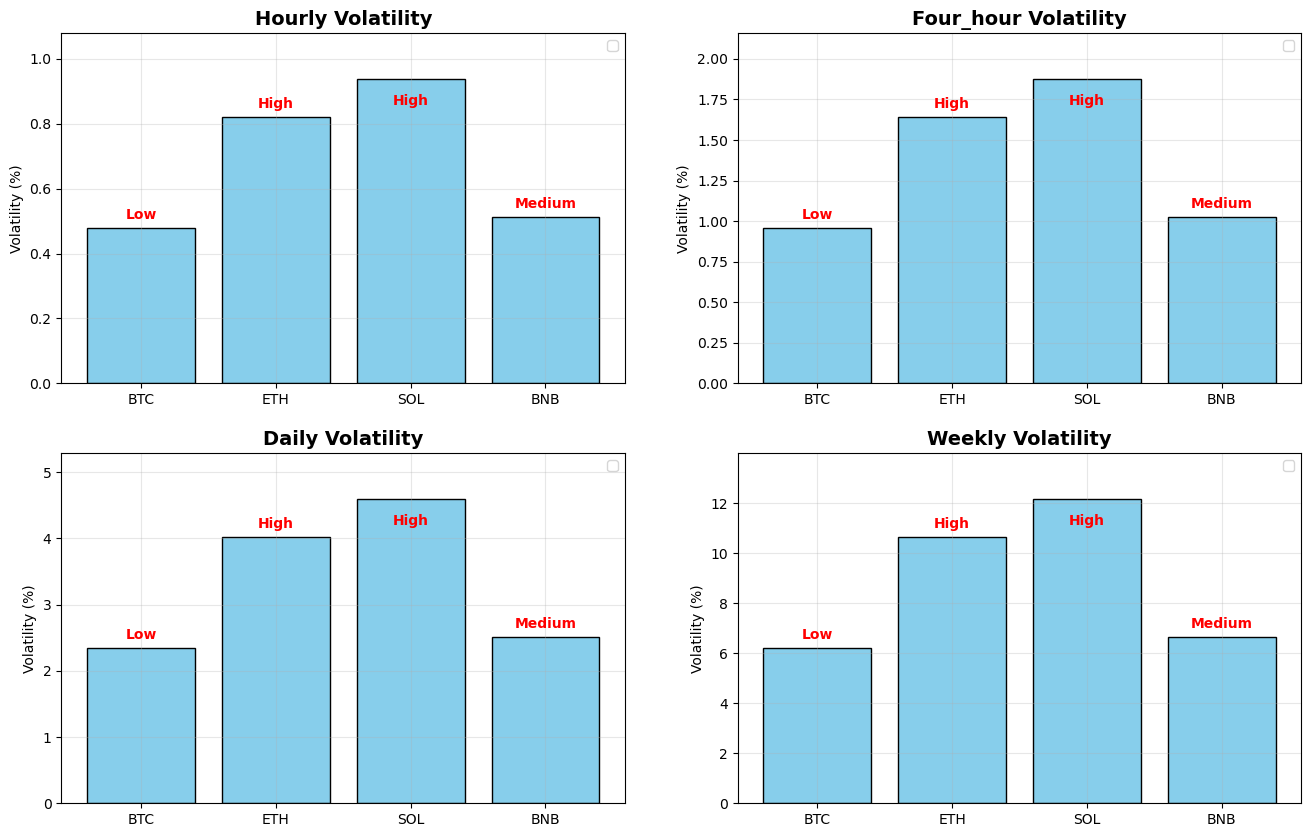

In [ ]:
def plot_volatility_grid(volatility_data, thresholds):
    timeframes = ["hourly", "four_hour" ,"daily", "weekly", "monthly", "annual"]
    symbols = list(volatility_data.keys())

    n_tf = len(timeframes)
    n_cols = n_tf 
    n_rows = int(np.ceil(n_tf / n_cols))
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for i, tf in enumerate(timeframes):
        ax = axes[i]
        vols = [volatility_data[s][f"{tf}_volatility"] for s in symbols]
        lower, upper = thresholds[tf]
        
        # Bar plot untuk setiap symbol
        bars = ax.bar(symbols, vols, color='skyblue', edgecolor='black')

        # Dapatkan nilai maksimum untuk memberi ruang pada teks
        max_vol = max(vols)
        ax.set_ylim(0, max_vol * 1.15)  # tambahkan margin 15% agar label tidak keluar
        
        # Annotate bars dengan status
        for j, bar in enumerate(bars):
            vol = vols[j]
            if vol < lower:
                status = "Low"
            elif vol > upper:
                status = "High"
            else:
                status = "Medium"

            # Jika bar terlalu tinggi, geser teks sedikit ke bawah
            text_y = vol + (max_vol * 0.02 if vol < max_vol * 0.9 else -max_vol * 0.05)
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                text_y,
                status,
                ha='center',
                va='bottom' if vol < max_vol * 0.9 else 'top',
                fontsize=10,
                fontweight='bold',
                color='red'
            )
        
        ax.set_title(f"{tf.capitalize()} Volatility", fontsize=14, fontweight='bold')
        ax.set_ylabel("Volatility (%)")
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.suptitle("Crypto Volatility and Threshold Classification", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Hitung thresholds seperti di kode sebelumnya
hourly_vols = np.array([v["hourly_volatility"] for v in volatility_analysis.values()])
four_hour_vols = np.array([v["four_hour_volatility"] for v in volatility_analysis.values()])
daily_vols = np.array([v["daily_volatility"] for v in volatility_analysis.values()])
weekly_vols = np.array([v["weekly_volatility"] for v in volatility_analysis.values()])
monthly_vols = np.array([v["monthly_volatility"] for v in volatility_analysis.values()])
annual_vols = np.array([v["annual_volatility"] for v in volatility_analysis.values()])

thresholds = {
    "hourly": np.percentile(hourly_vols, [33, 66]),
    "four_hour": np.percentile(four_hour_vols, [33, 66]),
    "daily": np.percentile(daily_vols, [33, 66]),
    "weekly": np.percentile(weekly_vols, [33, 66]),
    "monthly": np.percentile(monthly_vols, [33, 66]),
    "annual": np.percentile(annual_vols, [33, 66]),
}

plot_volatility_grid(volatility_analysis, thresholds)

In [ ]:
def explain_grid_concept() :
    print("1. Setup grid under current price")
    print("2. Buy when price hit drif level")
    print("3. Sell when TP hit")
    print("4. Repeat for systematic profit from volatility")

    # Example calculation
    initial_price_btc = 106000
    grid_spacing_daily_btc = 0.0338

    print(f"\nGrid Spacing : {grid_spacing_daily_btc*100}%")
    print("Grid Levels : ")

    for i in range (1,6) :
        level = initial_price_btc * (1 - i * grid_spacing_daily_btc)
        print(f"Grid {i} : ${level:,.0f} ({-i * grid_spacing_daily_btc * 100:.1f}%) from initial price")

explain_grid_concept()

1. Setup grid under current price
2. Buy when price hit drif level
3. Sell when TP hit
4. Repeat for systematic profit from volatility

Grid Spacing : 3.38%
Grid Levels : 
Grid 1 : $102,417 (-3.4%) from initial price
Grid 2 : $98,834 (-6.8%) from initial price
Grid 3 : $95,252 (-10.1%) from initial price
Grid 4 : $91,669 (-13.5%) from initial price
Grid 5 : $88,086 (-16.9%) from initial price


In [ ]:
btc_data = clean_crypto_data['BTC']
print(btc_data.columns)

# Calculate Metric
btc_data['Daily_Return'] = btc_data['Close'].pct_change()
btc_data['Daily_Range_Pct'] = (btc_data['High'] - btc_data['Low']) / btc_data['Close']

print(f"Loaded {len(btc_data)} records btc data")

print(btc_data[['Close', 'Daily_Range_Pct']].head())

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Loaded 364 records btc data
                                  Close  Daily_Range_Pct
Date                                                    
2024-10-20 00:00:00+00:00  69001.703125         0.018163
2024-10-21 00:00:00+00:00  67367.851562         0.039082
2024-10-22 00:00:00+00:00  67361.406250         0.018114
2024-10-23 00:00:00+00:00  66432.195312         0.033338
2024-10-24 00:00:00+00:00  68161.054688         0.034402


In [ ]:
class GridTrading : 
    def __init__(self, symbol, initial_price, grid_spacing_pct, num_grids=10, budget=1000):
        self.symbol = symbol
        self.initial_price = initial_price
        self.grid_spacing_pct = grid_spacing_pct
        self.num_grids = num_grids
        self.budget = budget

        # Calculate position size per grid
        self.position_size = budget / num_grids

        # Generate grid levels
        self.grid_levels = self._calculate_grid_levels()

        # Initialize trading state
        self.cash = budget
        self.positions = {}
        self.total_coin = 0.0
        self.realized_profit = 0.0

        print("\n=== Grid Trading Setup Details ===")
        print(f"Symbol: {self.symbol}")
        print(f"Initial Price: ${self.initial_price:,.2f}")
        print(f"Total Budget: ${self.budget:,.2f}")
        print(f"Position Size per Grid: ${self.position_size:,.2f}")

    def _calculate_grid_levels(self):
        """
        Calculate grid trading levels below the initial price based on specified spacing.
        Returns:
            list: List of price levels in descending order for grid trading.
        """
        if not isinstance(self.initial_price, (int, float)) or self.initial_price <= 0:
            raise ValueError("Initial price must be a positive number")
            
        if not isinstance(self.grid_spacing_pct, (int, float)) or self.grid_spacing_pct <= 0:
            raise ValueError("Grid spacing percentage must be a positive number")
            
        if not isinstance(self.num_grids, int) or self.num_grids <= 0:
            raise ValueError("Number of grids must be a positive integer")

        # Calculate grid levels with input validation
        levels = []
        total_discount = 0
        
        for i in range(1, self.num_grids + 1):
            # Calculate discount for current level
            total_discount = i * self.grid_spacing_pct / 100
            
            # Ensure discount doesn't exceed 100%
            if total_discount >= 1:
                break
                
            # Calculate price level
            level = self.initial_price * (1 - total_discount)
            levels.append(round(level, 2))

        return levels
    
    def _apply_fee(self, amount):
        return amount * (1 - self.fee_rate)

    def display_grid_setup(self):
       
        print("\nGrid Levels:")
        print("-" * 70)
        print(f"{'Level':^6} | {'Price':^15} | {'Discount %':^10} | {'USD Amount':^12} | {'Coin Amount':^12}")
        print("-" * 70)
        
        for i, level in enumerate(self.grid_levels):
            discount = ((self.initial_price - level) / self.initial_price) * 100
            coin_amount = self.position_size / level
            
            print(f"{i+1:^6} | ${level:>13,.2f} | {discount:>9.2f}% | ${self.position_size:>10,.2f} | {coin_amount:>11.5f}")
        
        print("-" * 70)
        print(f"Total Grids: {len(self.grid_levels)}")
        print(f"Grid Range: {self.grid_spacing_pct * self.num_grids:.1f}% below initial price")

    def execute_buy_order(self, current_price, verbose=True) :
        executed_orders = []

        for level in self.grid_levels:
            # Check jika price tersentuh sesuai level dan belum punya position
            if(current_price <= level and level not in self.positions):
                # Check if had enough cash
                if self.cash >= self.position_size:
                    quantity = self.position_size / level

                    # Execute Buy
                    self.positions[level] = {
                        'quantity' : quantity,
                        'buy_price' : level,
                        'timestamp' : datetime.now()
                    }

                    self.cash -= self.position_size
                    self.total_coin += quantity

                    executed_orders.append({
                        'type' : 'BUY',
                        'price' : level,
                        'quantity' : quantity,
                        'amount' : self.position_size
                    })

                    if verbose:
                        print(f"[BUY] {quantity:.5f} {self.symbol} at ${level:,.2f}")

        return executed_orders

    def execute_sell_order(self, current_price, profit_target_pct = 3.4, verbose=True) :
        executed_orders = []

        # Check semua active positions
        for level, position in list(self.positions.items()):
            target_price = position['buy_price'] * (1 + (profit_target_pct / 100))
            
            # Sell jika current_price >= target price
            if current_price >= target_price :
                sell_amount = position['quantity'] * current_price
                profit = sell_amount - self.position_size

                # Execute Sell
                self.cash += sell_amount
                self.total_coin -= position['quantity']
                self.realized_profit += profit

                executed_orders.append({
                    'type' : 'SELL',
                    'buy_price' : position['buy_price'],
                    'sell_price' : current_price,
                    'quantity' : position['quantity'],
                    'profit' : profit
                })

                if verbose:
                    print(f"[SELL] {position['quantity']:.5f} {self.symbol} at ${current_price:,.2f} | Profit: ${profit:,.2f}")

                del self.positions[level]
        
        return executed_orders

    def simulate_grid_trading(self, price_data, profit_target_pct=3.4) :
        print(f"Simulating Grid Trading for {self.symbol}")
        trading_log, portofolio_history = [], []

        for date, row in price_data.iterrows():
            current_price = float(row['Close'])
            # print(f'Ini harga sekarang : {current_price:,.2f}')

            # Execute trading logic
            buy_orders = self.execute_buy_order(current_price)
            sell_orders = self.execute_sell_order(current_price, profit_target_pct)

            # Log all trades
            for order in buy_orders + sell_orders :
                order['date'] = date
                trading_log.append(order)

            # Record portfolio state
            crypto_value = self.total_coin * current_price
            total_value = self.cash + crypto_value

            portofolio_history.append({
                'date' : date,
                'price' : current_price,
                'cash' : self.cash,
                'crypto_value' : crypto_value,
                'total_value' : total_value,
                'realized_profit' : self.realized_profit,
            })

        return pd.DataFrame(trading_log), pd.DataFrame(portofolio_history)


In [ ]:
if btc_data is not None : 
    initial_btc_price = float(btc_data['Close'].iloc[-1])

    btc_grid = GridTrading(
        symbol='BTC',
        initial_price=initial_btc_price,
        grid_spacing_pct=3.4,
        num_grids=18,
        budget=1000,
    )

    btc_grid.display_grid_setup()
    trading_log, portfolio_history = btc_grid.simulate_grid_trading(btc_data)

    print("\nSimulation Complete")

    print(f"Total Trades : {len(trading_log)}")
    print(f"Total BUY    : {len(trading_log[trading_log['type'] == 'BUY'])}")
    print(f"Total SELL   : {len(trading_log[trading_log['type'] == 'SELL'])}")
    


=== Grid Trading Setup Details ===
Symbol: BTC
Initial Price: $107,198.27
Total Budget: $1,000.00
Position Size per Grid: $55.56

Grid Levels:
----------------------------------------------------------------------
Level  |      Price      | Discount % |  USD Amount  | Coin Amount 
----------------------------------------------------------------------
  1    | $   103,553.52 |      3.40% | $     55.56 |     0.00054
  2    | $    99,908.78 |      6.80% | $     55.56 |     0.00056
  3    | $    96,264.04 |     10.20% | $     55.56 |     0.00058
  4    | $    92,619.30 |     13.60% | $     55.56 |     0.00060
  5    | $    88,974.56 |     17.00% | $     55.56 |     0.00062
  6    | $    85,329.82 |     20.40% | $     55.56 |     0.00065
  7    | $    81,685.08 |     23.80% | $     55.56 |     0.00068
  8    | $    78,040.34 |     27.20% | $     55.56 |     0.00071
  9    | $    74,395.60 |     30.60% | $     55.56 |     0.00075
  10   | $    70,750.86 |     34.00% | $     55.56 |     0.00

In [ ]:
# Simulate price touching grid level
test_price = btc_grid.grid_levels[4]
print(f"Simulating price drop to ${test_price:,.2f}")
buy_orders = btc_grid.execute_buy_order(test_price)

# Print portfolio status after buy
print("\nPortfolio Status after Buy:")
print(f"Cash: ${btc_grid.cash:.2f}")
print(f"Total {btc_grid.symbol}: {btc_grid.total_coin:.5f}")
print(f"Active Positions: {len(btc_grid.positions)}")

# Simulate price recovery
test_sell_price = test_price * 1.034  # 3.4% higher than buy price
print(f"\nSimulating price recovery to ${test_sell_price:,.2f}")
sell_orders = btc_grid.execute_sell_order(test_sell_price)

# Print portfolio status after sell
print("\nPortfolio Status after Sell:")
print(f"Cash: ${btc_grid.cash:.2f}")
print(f"Total {btc_grid.symbol}: {btc_grid.total_coin:.5f}")
print(f"Realized Profit: ${btc_grid.realized_profit:.2f}")
print(f"Active Positions: {len(btc_grid.positions)}")


Simulating price drop to $88,974.56
[BUY] 0.00054 BTC at $103,553.52
[BUY] 0.00056 BTC at $99,908.78
[BUY] 0.00058 BTC at $96,264.04
[BUY] 0.00060 BTC at $92,619.30
[BUY] 0.00062 BTC at $88,974.56

Portfolio Status after Buy:
Cash: $814.67
Total BTC: 0.00289
Active Positions: 5

Simulating price recovery to $91,999.70
[SELL] 0.00062 BTC at $91,999.70 | Profit: $1.89

Portfolio Status after Sell:
Cash: $872.11
Total BTC: 0.00227
Realized Profit: $94.34
Active Positions: 4


In [ ]:
def plot_performance(df, cryptos, title="Crypto Performance Comparison"):
    df_normalized = (df / df.iloc[0] - 1) * 100  # Normalisasi ke percentage
    colors = generate_colors(len(cryptos))
    
    plt.figure(figsize=(16, 8))

    for i, symbol in enumerate(cryptos):
        plt.plot(df_normalized.index, df_normalized[symbol], label=symbol, color=colors[i], linewidth=2)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (%)', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(0, color='black', linestyle='--', alpha=0.8)

    # Add latest performance indicator on the plot
    latest_change = df_normalized.iloc[-1].round(1)
    textstr = 'Latest Performance:\n' + '\n'.join([f"{k}: {v:.2f}%" for k, v in latest_change.items()])
    plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# plot_performance(crypto_data_history, crypto_symbols)

In [ ]:
def plot_daily_return(df, cryptos=crypto_symbols): 
    colors = generate_colors(len(cryptos))
    # Calculate daily returns
    returns = df.pct_change().dropna()

    # Calculate volatility
    volatility = returns.std() * np.sqrt(365) * 100

    plt.figure(figsize=(12, 6))

    # Subplot 1: Daily Returns Distribution
    plt.subplot(1, 2, 1)
    for i, symbol in enumerate(cryptos):
        plt.hist(returns[symbol] * 100, bins=30, alpha=0.6, label=symbol, color=colors[i])
    
    plt.title('Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Volatility Rankings
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(len(cryptos)), volatility, color=colors, alpha=0.7)
    plt.title('Annualized Volatility Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Cryptocurrency', fontsize=12)
    plt.ylabel('Volatility (%)', fontsize=12)
    plt.xticks(range(len(cryptos)), [c.replace('-USD', '') for c in df.columns])
    plt.grid(True, alpha=0.3)

    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{volatility.iloc[i]:.0f}%', 
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# plot_daily_return(crypto_data_history)


In [ ]:
# Data Acquisition
